In [1]:
import numpy as np 
import math as math
import pandas as pd
import seaborn as sns
import sklearn as sk
import missingno as msno
#import matplot
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import dataframe_image as dfi

import matplotlib
import pathlib
import statistics
import itertools

from collections import Counter

from scipy.stats import probplot, binned_statistic

from pathlib import Path

from statistics import mean

from sklearn import set_config

from sklearn.model_selection import cross_validate, train_test_split, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold, KFold, cross_val_score, StratifiedKFold, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import plot_confusion_matrix  

#from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, LabelBinarizer, FunctionTransformer
from sklearn.tree import plot_tree
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPRegressor

In [2]:
def clinical_import():
    clinical_info = pd.read_csv('UPENN-GBM_clinical_info_v1.0.csv',index_col=0)
    clinical_info.replace({'Not Available':np.NaN,'Not Applicable':np.NaN},inplace=True)
    clinical_info['Survival_from_surgery_days'] = pd.to_numeric(clinical_info['Survival_from_surgery_days']) 
    clinical_info['Time_since_baseline_preop'] = pd.to_numeric(clinical_info['Time_since_baseline_preop'])
    clinical_info['KPS'] = pd.to_numeric(clinical_info['KPS'])
    clinical_info['PsP_TP_score'] = pd.to_numeric(clinical_info['PsP_TP_score'])
    return clinical_info 

radiomic_content = {}   
for file_path in pathlib.Path('./RADIOMIC FEATURES').glob('Radiomic_Features_CaPTk_*.csv'):
    df = pd.read_csv(file_path, index_col=0)
    radiomic_content[file_path.stem] = df
    
def radiomic_data_per_subject(subjectID):
    level1 = [] 
    level2 = [] #imaging modes 
    level3 = [] #dataframes
    
    for key in radiomic_content.keys():
        temp_df = radiomic_content[key]
    
        '''create dataframe which includes feature values for all modalities (for each subject)'''
        if subjectID in list(temp_df.index):
            level1.append(subjectID)
            temp_df = pd.DataFrame(temp_df.xs(subjectID))
            '''column headers == new indices (aka radiomic features)'''
            '''subjectID == new column header (to be replaced with type of scan)'''
            
        
            if 'automaticsegm' in key:
                if 'DSC_ap' in key:
                    category = 'AUTO_SEGMENTATION_DSC'
                    mode = str(key.replace('Radiomic_Features_CaPTk_automaticsegm_DSC_ap-',''))
                    temp_df.set_axis(labels = [name.replace('DSC_ap-' + mode + '_','') for name in list(temp_df.index)], axis='index', inplace=True)
                    temp_df.rename(columns={subjectID:mode},inplace=True)
                    
                    #if category not in level2:
                        #level2.append(category)
                    level2.append((category,mode))
                    
                else:
                    category = 'AUTO_SEGMENTATION'
                    mode = str(key.replace('Radiomic_Features_CaPTk_automaticsegm_',''))
                    temp_df.set_axis(labels = [name.replace(mode + '_','') for name in list(temp_df.index)], axis='index', inplace=True)
                    temp_df.rename(columns={subjectID:mode},inplace=True)
                    
                    #if category not in level2:
                        #level2.append(category) 
                    level2.append((category,mode))
                    
            else:
                category = 'SEGMENTATION'
                mode = str(key.replace('Radiomic_Features_CaPTk_segm_',''))
                temp_df.set_axis(labels = [name.replace(mode + '_','') for name in list(temp_df.index)], axis='index', inplace=True)
                temp_df.rename(columns={subjectID:mode},inplace=True)
                
                #if category not in level2:
                    #level2.append(category)
                level2.append((category,mode))

            level3.append(temp_df)
                  
        else:
            continue
            
    radiomic_data = pd.concat(level3, keys=level2, axis=1) 
    radiomic_data = radiomic_data.droplevel(1,axis=1)
            
    radiomic_data = radiomic_data.iloc[0:20,:] 
    
    return radiomic_data

def split_list_by_type(mixed_list):
    int_list = [i for i in mixed_list if isinstance(i, int)]
    str_list = [i for i in mixed_list if isinstance(i, str)]
    return int_list, str_list

def myFunc(unit):
    return len(unit)
 

def data_processor(df, return_scaler=False):
    numeric_df = df.select_dtypes(include=['float','int64']) 
    numeric_int_columns, numeric_str_columns = split_list_by_type(numeric_df.columns)
    numeric_str_columns.sort(reverse=True, key=myFunc)
    numeric_columns = numeric_str_columns + numeric_int_columns
    numeric_df = numeric_df.reindex(columns=numeric_columns)
    print('0th index of scaler', numeric_df.columns[0]) #ensure survival - used for reverse scaling
    
    categorical_df = df.select_dtypes(include=['object','bool']) #.loc[:,['Gender','IDH1','GTR_over90percent']]
  
    scaler = StandardScaler()
    scaler.fit(numeric_df.values)
    scaled_df = pd.DataFrame(scaler.transform(numeric_df.values), columns=numeric_df.columns, index=numeric_df.index)

    le = LabelEncoder()
    columns = categorical_df.columns
    categorical_df[columns] = categorical_df[columns].apply(lambda col:le.fit_transform(col))
    
    processed_df = pd.merge(categorical_df,scaled_df,left_index=True,right_index=True)
    
    xdata = processed_df.loc[:,processed_df.columns!='Survival_from_surgery_days']
    ydata = processed_df[['Survival_from_surgery_days']]
    
    if return_scaler is False:
        return xdata, ydata
    else:
        return scaler   
    
def dropped_column_df(df,threshold):
    dropped_columns = []
    for col in df.columns:
        if df[col].isnull().sum() > threshold*(df.shape[0]):
            #dropped_columns.append(col)
            df = df.drop(col, axis='columns')
    print('number of columns dropped', len(dropped_columns))
    return df


def filter_columns(df,threshold):
    numeric_data = df.select_dtypes(include=['float','int64']) 
    categorical_data = df.loc[:,['Gender','IDH1','GTR_over90percent']]
    scaler = StandardScaler()
    scaler.fit(numeric_data.values)
    scaled_df = pd.DataFrame(scaler.transform(numeric_data.values), columns=numeric_data.columns)
    col_corr = set() # set of all the names of deleted columns
    corr_matrix = scaled_df.corr(method='kendall') #most appropriate method 
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in scaled_df.columns:
                    del scaled_df[colname] # deleting the column from the dataset
    
    reduced_columns = list(scaled_df.columns)
    #manually reinclude clinical data
    if 'Age_at_scan_years' not in reduced_columns:
        reduced_columns.append('Age_at_scan_years')
    if 'Survival_from_surgery_days' not in reduced_columns:   
        reduced_columns.append('Survival_from_surgery_days')
    for cat_col in categorical_data.columns:
        reduced_columns.append(cat_col)   
    reduced_df = df.loc[:, reduced_columns]
    return reduced_df #original unscaled values

In [3]:
C = clinical_import()

C_base = C.dropna(subset=['Survival_from_surgery_days'])
C_base = C_base.drop('PsP_TP_score',axis='columns')
C_base = C_base.drop('Time_since_baseline_preop', axis='columns')
C_base = C_base.dropna(subset=['GTR_over90percent'])

R_base = pd.DataFrame(columns=[i for i in range(0,1320)]) #matching only those which have necessary clinical data
  
for patient in C_base.index:
    radiomic = radiomic_data_per_subject(patient)
    radiomic_list = radiomic.values.tolist()
    flattened_radiomic_list = list(itertools.chain.from_iterable(radiomic_list))
    R_base = R_base.append(pd.Series(flattened_radiomic_list, index=R_base.columns[:len(flattened_radiomic_list)]), ignore_index=True)

R_base['Subject_ID'] = list(C_base.index)
R_base = R_base.set_index('Subject_ID')

df = pd.merge(C_base,R_base,left_index=True,right_index=True)
print('full dataset', df.shape)


full dataset (424, 1327)


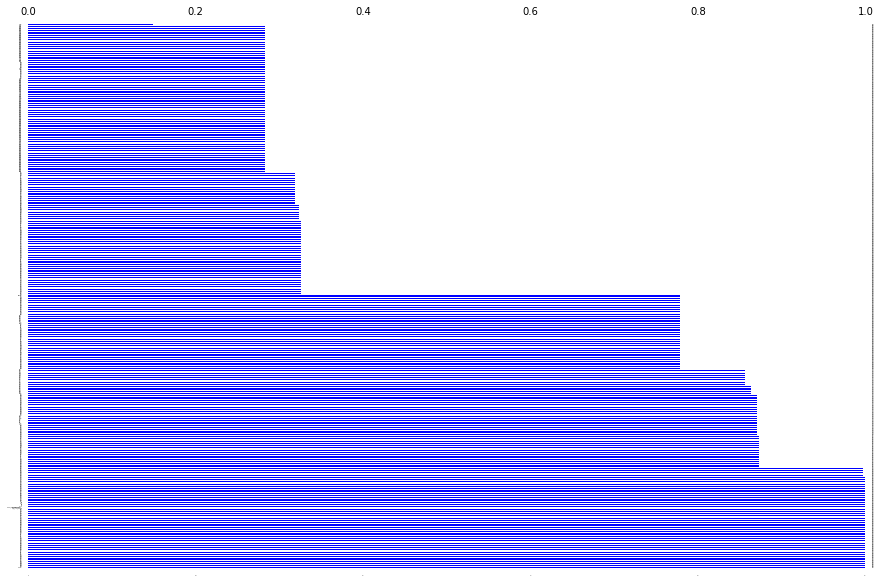

In [4]:
plt.figure(figsize=(5,5))
msno.bar(df, sort="descending", figsize=(15,10), fontsize=1, color='blue')

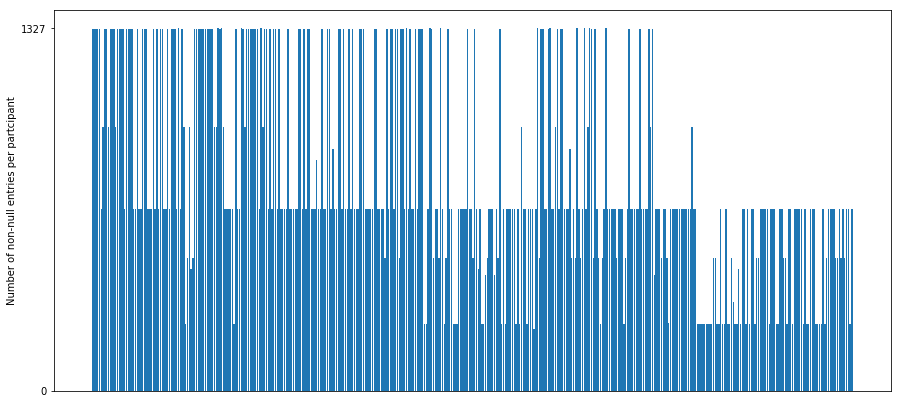

In [6]:
lenghts = []
x = []

for j in range(0,len(df.index)):
    x.append(j)
    lenghts.append(df.iloc[j:j+1,:].count().sum())
    
#lenghts.sort()
plt.figure(figsize=(15,7))
plt.bar(x,lenghts)
plt.ylabel('Number of non-null entries per partcipant')
#plt.xlabel('number of data entires (patients)')
plt.xticks([])
plt.yticks([0,df.shape[1]])
#plt.title('corresponding radiomic dataset')
plt.show()

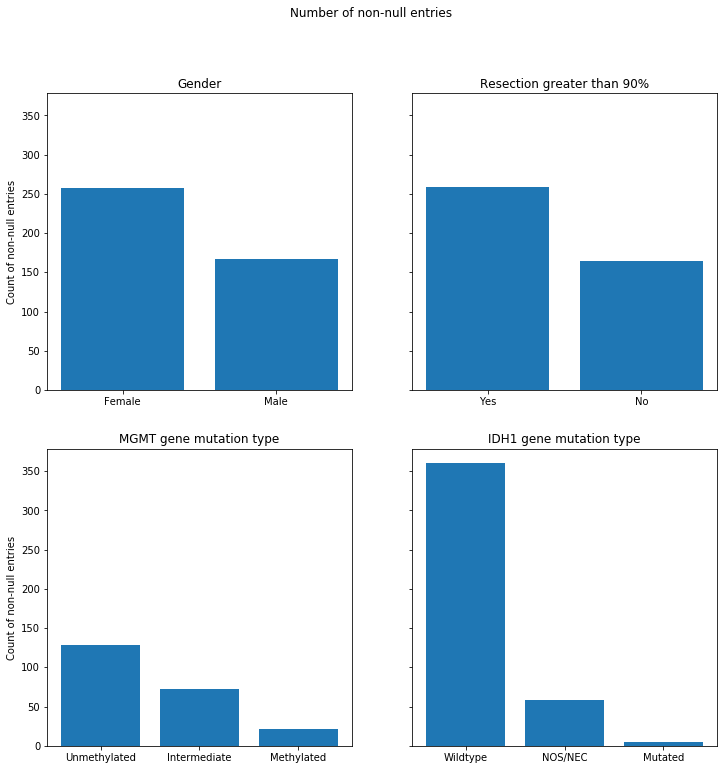

In [9]:
counts1 = list(df['Gender'].value_counts())
counts2 = list(df['GTR_over90percent'].value_counts())
counts3 = list(df['MGMT'].value_counts())
counts4 = list(df['IDH1'].value_counts())

fig, axes = plt.subplots(2,2,sharex=False, sharey=True)
fig.set_figheight(12)
fig.set_figwidth(12)
fig.suptitle('Number of non-null entries')
axes[0,0].bar(['Female','Male'],counts1)
#axes[0,0].xlabel('Gender')
axes[0,0].set_title('Gender')
axes[0,0].set_ylabel("Count of non-null entries")

axes[0,1].bar(['Yes','No'],counts2)
axes[0,1].set_title('Resection greater than 90%')
#axes[0,1].ylabel("No. of non-null entries")

axes[1,0].bar(['Unmethylated','Intermediate','Methylated'],counts3)
axes[1,0].set_title('MGMT gene mutation type')
axes[1,0].set_ylabel("Count of non-null entries")

axes[1,1].bar(['Wildtype','NOS/NEC','Mutated'],counts4)
axes[1,1].set_title('IDH1 gene mutation type')
#axes[1,1].ylabel("No. of non-null entries")



plt.show()

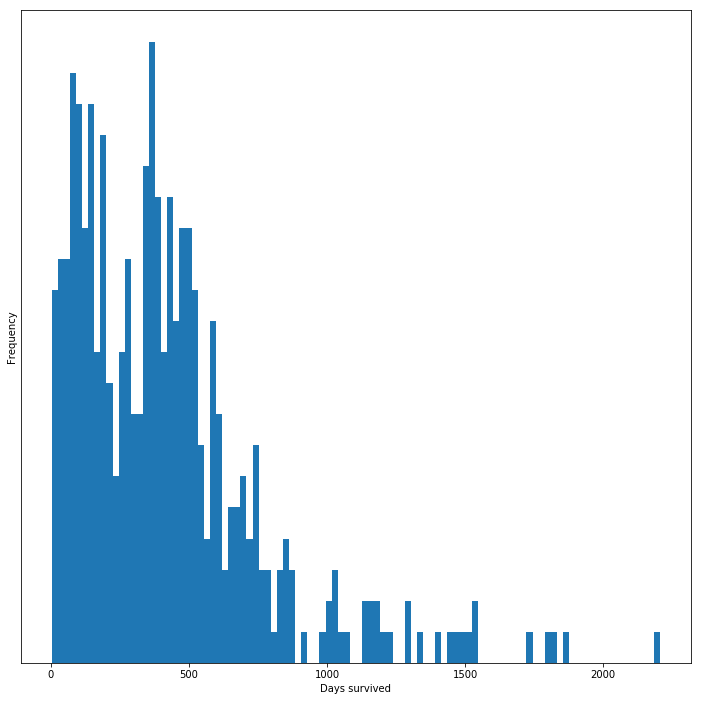

In [6]:
plt.figure(figsize=(12,12))
plt.hist(df['Survival_from_surgery_days'], bins=100, density=True)
plt.xlabel('Days survived')
plt.ylabel('Frequency')
plt.yticks([])
plt.show()

In [4]:
parta_rows = [424,423,363,330,330,168,168,59,48,14,14]
parta_cols = [245,255,485,665,665,666,666,966,1326,1327,1327]

partb_rows = [222,424]
partb_cols = [1327,1326]

partc_rows = [424,423,363,330,330,168,168,424,222]
partc_cols = [129,149,366,448,448,434,434,630,600]

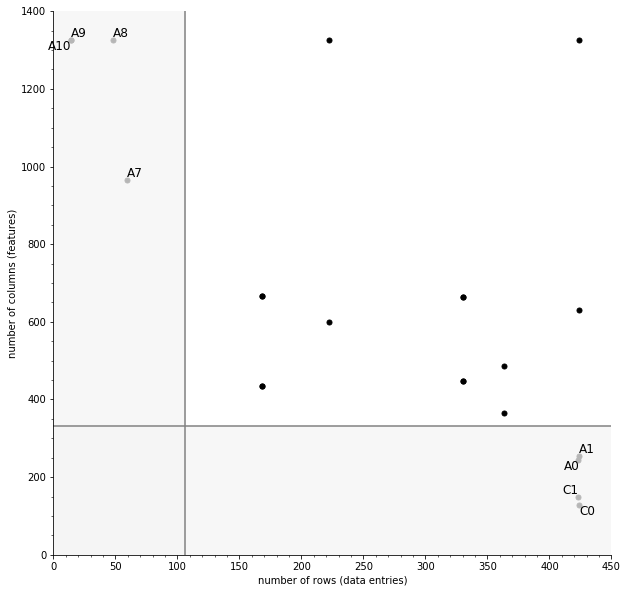

In [22]:
plt.figure(figsize=(10,10))

plt.axhline(y=0.25*df.shape[1], ls='-', color='grey', xmin=0, xmax=425)
plt.axhspan(ymin=0,ymax=0.25*df.shape[1],color='whitesmoke', alpha=0.75, xmin=0, xmax=425)
plt.axvline(x=0.25*df.shape[0], ls='-', color='grey', ymin=0, ymax=1330) #,ymin=70, ymax=150,color='r')   
plt.axvspan(xmin=0,xmax=0.25*df.shape[0],color='whitesmoke', alpha=0.75, ymin=0, ymax=1330)


plt.scatter(parta_rows, parta_cols, marker='o', s=25 , edgecolors='black', color='black')
plt.scatter(partb_rows, partb_cols, marker='o', s=25 , edgecolors='black', color='black')
plt.scatter(partc_rows, partc_cols, marker='o', s=25 , edgecolors='black', color='black')
plt.xlabel('number of rows (data entries)')
plt.ylabel('number of columns (features)')


plt.text(59, 966, 'A7', va='bottom', ha='left', fontsize='large')
plt.text(48, 1326, 'A8', va='bottom', ha='left', fontsize='large')
plt.text(14, 1327, 'A9', va='bottom', ha='left', fontsize='large')
plt.text(14, 1327, 'A10', va='top', ha='right', fontsize='large')

plt.text(424, 245, 'A0', va='top', ha='right', fontsize='large')
plt.text(424, 255, 'A1', va='bottom', ha='left', fontsize='large')
plt.text(424, 129, 'C0', va='top', ha='left', fontsize='large')
plt.text(423, 149, 'C1', va='bottom', ha='right', fontsize='large')

plt.minorticks_on()


    
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlim(0, 450)
plt.ylim(0, 1400)
plt.show()